In [1]:
import scipy.spatial.distance
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

sns.set()

from biobank_olink.constants import PROJECT_ROOT

In [2]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("pred_diagnosis")]
results = pd.DataFrame(chain.from_iterable(results))

results.loc[results["ext"].isna(), "ext"] = False
results["imm_infla"] = results.panel == "IMMUNE_INFL2"
results.loc[results.imm_infla, "olink"] = False
panels = results.panel.unique()

agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(["years", "lifestyle", "ext", "imm_infla", "olink"], dropna=False).agg(
    **agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  \
years lifestyle ext   imm_infla olink                                    
5     False     False False     False        0.672696            206.6   
      True      False False     False        0.717286            206.8   
                True  False     False        0.728056            307.0   
                                True         0.754554            307.0   
                      True      False        0.738449            213.6   
10    False     False False     False        0.666914            207.0   
      True      False False     False        0.709528            207.0   
                True  False     False        0.715009            307.0   
                                True         0.743103            307.0   
                      True      False        0.725819            214.8   

                                       mean_best_trial_no  mean_n_estimators  \
years lifestyle ext   imm_infla olink                                          
5     False     False False     False               177.8             1179.4   
      True      False False     False               173.8             2289.4   
                True  False     False               259.8             3116.8   
                                True                173.8             3600.4   
                      True      False               157.0             2986.0   
10    False     False False     False               163.4             1070.2   
      True      False False     False               162.0             2856.2   
                True  False     False               234.2             2976.2   
                                True                234.2             4141.4   
                      True      False               160.8             2854.0   

                                       count  
years lifestyle ext   imm_infla olink         
5     False     False False     False      5  
      True      False False     False      5  
                True  False     False      5  
                                True       5  
                      True      False      5  
10    False     False False     False      5  
      True      False False     False      5  
                True  False     False      5  
                                True       5  
                      True      False      5

In [3]:
results_gb = results.groupby(["years", "lifestyle", "ext", "imm_infla", "olink"], as_index=False)
results_aucs = results_gb.agg({
    "auc_score": "mean",
    "x_shape": lambda v: v.values[0][1] if len(v.dropna()) > 0 else np.nan,
    "y_test": lambda v: np.concatenate(v.values),
    "y_proba": lambda v: np.concatenate(v.values),
})
results_aucs["auc_concat"] = results_aucs.apply(
    lambda row: roc_auc_score(row["y_test"], row["y_proba"]), axis=1)
results_aucs["exp_case"] = results_aucs[["lifestyle", "ext", "imm_infla", "olink"]].apply(
    lambda row: "+".join(row.index[row].tolist()), axis=1)
results_aucs["exp_case"] = results_aucs["exp_case"].apply(
    lambda v: "age+sex" + ("+" if v else "") + v)
results_aucs = results_aucs.pivot(index=["exp_case", "x_shape"], columns="years",
                                  values=["auc_score", "auc_concat"])
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs

auc_score           auc_concat          
years                                        5         10         5         10
age+sex (2)                            0.672696  0.666914   0.552426  0.605319
age+sex+lifestyle (18)                 0.717286  0.709528   0.716557  0.709143
age+sex+lifestyle+ext (35)             0.728056  0.715009   0.724161  0.713943
age+sex+lifestyle+ext+imm_infla (988)  0.738449  0.725819   0.682311  0.725632
age+sex+lifestyle+ext+olink (2750)     0.754554  0.743103   0.750189  0.742666

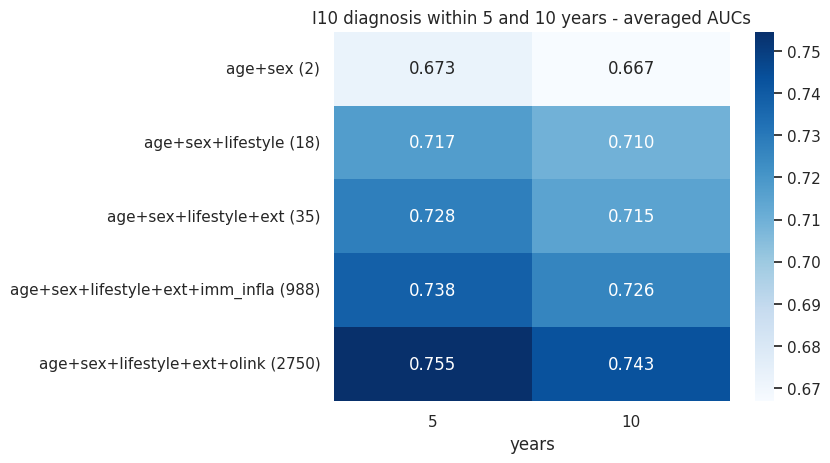

In [4]:
heatmap_kwargs = dict(annot=True, fmt=".3f", cmap="Blues")
# heatmaps
sns.heatmap(data=results_aucs["auc_score"], **heatmap_kwargs)
plt.title("I10 diagnosis within 5 and 10 years - averaged AUCs")
plt.show()

# sns.heatmap(data=results_aucs["auc_concat"], **heatmap_kwargs)
# plt.title("I10 diagnosis within 5 and 10 years - concatenated AUCs")
# plt.show()

In [5]:
from biobank_olink.constants import PROJECT_DATA

years = 10

two_ex_df = pd.read_csv(
    PROJECT_DATA / "feat_importances" / "two_extremes_xgb_corr0.9_sbp_th0.35.csv", index_col=0)

In [6]:
feat_imps = results.loc[
    (results[["lifestyle", "ext", "olink"]].all(axis=1))
    &
    (results["years"] == years)
    ].shap_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps = feat_imps.rank(ascending=False).mean(axis=1).sort_values(ascending=True)
feat_imps.name = "pred_diag_imp"
feat_imps = feat_imps.to_frame()

In [7]:
feat_imps2 = feat_imps.merge(two_ex_df, left_index=True, right_index=True, how="left")
feat_imps2.rename(columns={"shap_importance_rank": "two_extremes_sbp_imps"}, inplace=True)
feat_imps2[["pred_diag_imp", "two_extremes_sbp_imps", "panel"]]

,pred_diag_imp,two_extremes_sbp_imps,panel
age,1.0,NaN,NaN
REN,2.0,1.0,"['cardiometabolic', 'bp', 'renal']"
GDF15,3.2,508.4,['cardiometabolic']
HAVCR1,4.0,46.0,"['oncology', 'immune', 'imn_inf2']"
ADM,6.2,984.4,"['oncology', 'infl2', 'bp', 'renal', 'imn_inf2']"
...,...,...,...
alcohol_1.0,2471.1,NaN,NaN
smoking_2.0,2471.1,NaN,NaN
physactivity_2.0,2471.1,NaN,NaN
alcohol_6.0,2471.1,NaN,NaN


## Pred diag2 experiment

In [8]:
seed = 42

In [9]:
from scipy.spatial.distance import squareform, pdist
from biobank_olink.dataset import load_olink_and_covariates, get_olink_panel_mapping

from sklearn.model_selection import train_test_split

ol_df, cov_df = load_olink_and_covariates(0, 0, 0.9)
htn_cov_df = cov_df.loc[cov_df.HTNgroup == 1].copy()
ntn_cov_df = cov_df.loc[cov_df.HTNgroup == 0].copy()
ntn_cov_df = ntn_cov_df.loc[ntn_cov_df.timeHTNcoxfinal >= 0].copy()
ntn_y = ntn_cov_df.HTNcaseCoxfinal == 1
ntn_cov_df1, ntn_cov_df2 = train_test_split(ntn_cov_df, test_size=0.5, stratify=ntn_y,
                                            random_state=seed)

correction_df = pd.concat([htn_cov_df, ntn_cov_df1])
correction_df = correction_df[["sex", "age", "bmi"]]
# standardize selected data
correction_df = (correction_df - correction_df.mean()) / correction_df.std()
# use Euclidean distance
similarities = squareform(pdist(correction_df, metric="euclidean"))
np.fill_diagonal(similarities, np.inf)
similarities_df = pd.DataFrame(
    similarities, index=correction_df.index, columns=correction_df.index
)
similarities_sub_df = similarities_df.loc[htn_cov_df.index, ntn_cov_df1.index]
# find the most similar pairs
paired_up_df = similarities_sub_df.idxmin().to_frame("p2_id")
paired_up_df["dist"] = similarities_df.min()
paired_up_df2 = similarities_sub_df.T.idxmin().to_frame("p2_id")
paired_up_df2["dist"] = similarities_df.T.min()
paired_up_df = pd.concat([paired_up_df, paired_up_df2])
paired_up_df.sort_values(by="dist", inplace=True)

chosen = set()
for p1_idx, (p2_idx, _) in paired_up_df.iterrows():
    if p1_idx in chosen or p2_idx in chosen:
        continue
    chosen.add(p1_idx)
    chosen.add(p2_idx)
chosen_cov_df = cov_df.loc[list(chosen)]

x = ol_df.loc[chosen_cov_df.index].copy()
x = x.loc[:, x.columns.isin(get_olink_panel_mapping()["cardiometabolic"])]
y = chosen_cov_df.index.isin(htn_cov_df.index).reshape(-1, 1)

[Memory]0.0s, 0.0min    : Loading load_olink_and_covariates...


In [10]:
ntn_cov_df

,sex,bmi,fastingtime,alcohol,smoking,age,sbp,dbp,pp,HTNgroup,unrelated,HTNcaseCoxfinal,timeHTNcoxfinal,physactivity,deprivation,educationuni
eid,,,,,,,,,,,,,,,,
1000366,1,23.7966,2.0,2.0,1.0,66,136.5,82.5,54.0,0,Yes,0,4823,2.0,-4.87,0.0
1001182,0,26.7185,6.0,2.0,0.0,62,126.5,75.5,51.0,0,NaN,1,1349,0.0,-0.68,0.0
1001297,0,23.5351,4.0,1.0,0.0,48,124.0,78.5,45.5,0,Yes,0,5655,1.0,1.56,1.0
1001557,1,29.4740,4.0,6.0,0.0,47,138.0,88.0,50.0,0,Yes,0,4913,2.0,-2.81,1.0
1001755,0,24.0218,3.0,6.0,0.0,53,128.0,68.0,60.0,0,Yes,0,5457,1.0,-0.54,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023026,0,22.7441,2.0,1.0,0.0,40,115.5,69.5,46.0,0,Yes,0,4741,2.0,-3.51,0.0
6023060,0,25.3906,4.0,3.0,1.0,41,125.0,75.5,49.5,0,Yes,0,5018,1.0,0.24,0.0
6023200,1,24.3757,2.0,1.0,1.0,62,111.5,59.0,52.5,0,Yes,0,4771,2.0,-3.02,0.0


In [33]:
from xgboost import XGBClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,
                                                    random_state=seed)
model = XGBClassifier(tree_method="hist", random_state=seed)
model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, y_proba)

0.6541723693846115

In [34]:
x_ntn2 = ol_df.loc[ntn_cov_df2.index, x.columns].copy()

In [35]:
y_pred = model.predict_proba(x_ntn2)[:, 1]

In [36]:
y_ntn2 = (ntn_cov_df2.HTNcaseCoxfinal == 1)
y_ntn2.name = "event"
y_ntn2 = y_ntn2.astype(int).to_frame()
y_ntn2["y_pred"] = y_pred
y_ntn2["duration"] = ntn_cov_df2.timeHTNcoxfinal
y_ntn2.loc[~y_ntn2.event.astype(bool), "duration"] = y_ntn2.duration.max()
y_ntn2["group"] = pd.qcut(y_ntn2.y_pred, q=2, labels=False)
ntn_cov_df2["group"] = y_ntn2["group"]
y_ntn2.groupby("group").event.sum()

group
0    302
1    445
Name: event, dtype: int64

Text(0.5, 1.0, 'Groups from predictions')

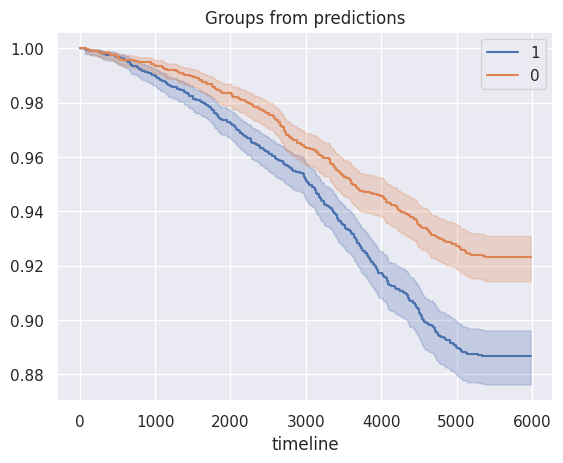

In [37]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
for group in y_ntn2['group'].unique():
    group_data = y_ntn2[y_ntn2['group'] == group]
    kmf.fit(group_data['duration'], group_data['event'], label=group)
    ax = kmf.plot()
ax.set_title(f"Groups from predictions")

In [38]:
import scipy

np.random.seed(seed)

target_cols = ["age", "bmi", "sbp", "dbp", "sex"]
target_props = ntn_cov_df2.groupby("group")[target_cols].mean()
df = ntn_cov_df2[target_cols]
g1_index, g2_index = train_test_split(df.index.values, train_size=0.5, random_state=seed)
n_iters = 5_000
p = 0.9

def swap_indices(idx1, idx2):
    temp = g2_index[idx2]
    g2_index[idx2] = g1_index[idx1]
    g1_index[idx1] = temp
    
def calc_score(current_props, target_props):
    return scipy.spatial.distance.euclidean(current_props, target_props)
    
score1 = calc_score(df.loc[g1_index].mean(), target_props.loc[0])
score2 = calc_score(df.loc[g2_index].mean(), target_props.loc[1])

for _ in range(n_iters):
    idx1 = np.random.randint(low=0, high=len(g1_index))
    idx2 = np.random.randint(low=0, high=len(g2_index))
    swap_indices(idx1, idx2)

    new_score1 = calc_score(df.loc[g1_index].mean(), target_props.loc[0])
    new_score2 = calc_score(df.loc[g2_index].mean(), target_props.loc[1])

    if (new_score1 > score1 or new_score2 > score2) and np.random.rand() < p:
        print(f"Change rejected")
        swap_indices(idx1, idx2)
    else:
        print(f"Change accepted: score1 -> {score1 - new_score1}, score2 -> {score2 - new_score2}")
        score1 = new_score1
        score2 = new_score2

Change accepted: score1 -> 0.003014518888512896, score2 -> 0.0030137688824010134
Change rejected
Change rejected
Change rejected
Change rejected
Change accepted: score1 -> 0.0024024493662060387, score2 -> 0.002401841126755677
Change accepted: score1 -> -0.007216494014518293, score2 -> -0.007214644908775547
Change rejected
Change accepted: score1 -> 0.0009269822487101287, score2 -> 0.0009267210290446748
Change rejected
Change accepted: score1 -> 0.0021973861018227403, score2 -> 0.002196755949044338
Change accepted: score1 -> 0.0030163368470197405, score2 -> 0.003015551014965201
Change accepted: score1 -> 0.005355016241015864, score2 -> 0.0053536574414856375
Change rejected
Change accepted: score1 -> 0.0034641983734560178, score2 -> 0.0034633286630487703
Change rejected
Change rejected
Change accepted: score1 -> 0.004874453821356539, score2 -> 0.004873289002725212
Change rejected
Change accepted: score1 -> 0.007141623830838384, score2 -> 0.007139832320729678
Change accepted: score1 -> 0.

In [39]:
ntn_cov_df2["random_group"] = ntn_cov_df2.index.isin(g2_index).astype(int)
print(f"Groups similarity: {(ntn_cov_df2.group == ntn_cov_df2.random_group).mean():.2%}")
ntn_cov_df2.groupby("random_group")[target_cols].mean() - target_props

Groups similarity: 52.82%


,age,bmi,sbp,dbp,sex
random_group,,,,,
0,-0.003356,-0.001486,0.002251,0.001858,0.000345
1,0.003148,0.001327,-0.003145,-0.002557,-0.000356


In [40]:
for g, v in y_ntn2.groupby(ntn_cov_df2["group"]).event.sum().items():
    print(f"Group {g}: {v} events")
for g, v in y_ntn2.groupby(ntn_cov_df2["random_group"]).event.sum().items():
    print(f"Random {g}: {v} events")

Group 0: 302 events
Group 1: 445 events
Random 0: 344 events
Random 1: 403 events


Text(0.5, 1.0, 'Random groups')

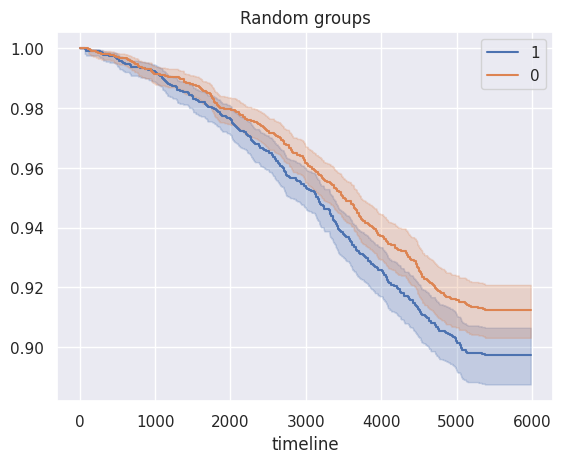

In [41]:
kmf = KaplanMeierFitter()
y_ntn2["random_group"] = ntn_cov_df2["random_group"]
for group in y_ntn2['random_group'].unique():
    group_data = y_ntn2[y_ntn2['random_group'] == group]
    kmf.fit(group_data['duration'], group_data['event'], label=group)
    ax = kmf.plot()
ax.set_title(f"Random groups")

## The above repeated 100 times

/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'immune_infla2 (val_auc=0.612±0.01)')

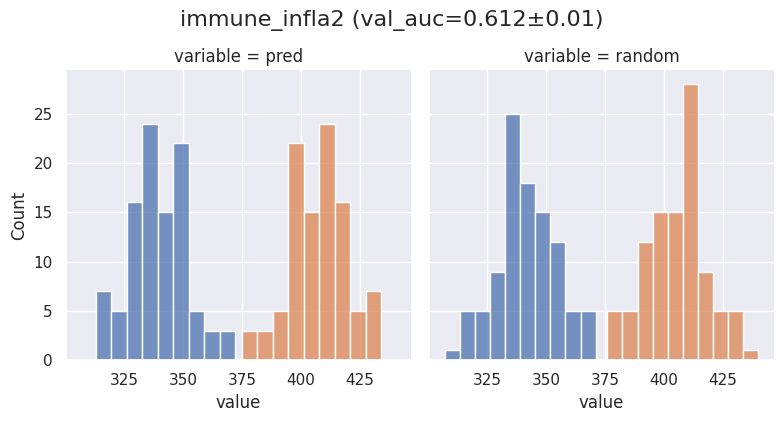

In [38]:
repeated_df = pd.read_json(PROJECT_ROOT / "results" / "pred_diag2_xgb_corr0.9_immune_infla2.json")
val_auc_mean, val_auc_std = repeated_df["val_auc_score"].agg(["mean", "std"])
repeated_df = repeated_df.iloc[:, 1:].melt()
repeated_df[["variable", "group"]] = repeated_df["variable"].str.split("_", expand=True)[[0, 2]]
g = sns.FacetGrid(repeated_df, col="variable", hue="group", height=4)
g.map(sns.histplot, "value")
g.fig.suptitle(f'immune_infla2 (val_auc={val_auc_mean:.3f}±{val_auc_std:.2f})', fontsize=16, y=1.05)

/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'cardiometabolic (val_auc=0.660±0.01)')

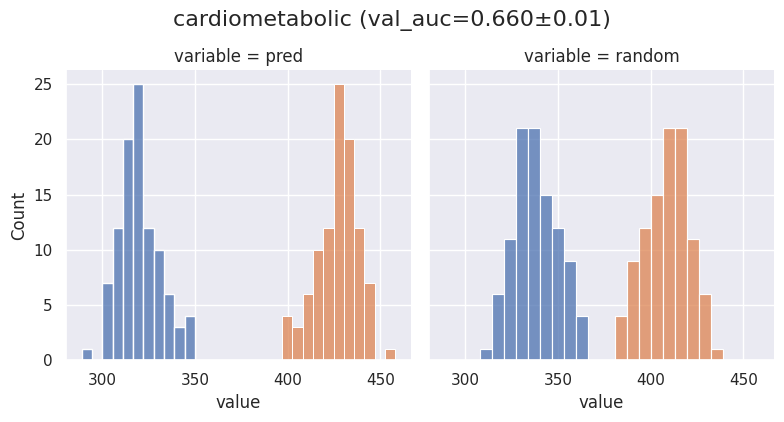

In [39]:
repeated_df = pd.read_json(PROJECT_ROOT / "results" / "pred_diag2_xgb_corr0.9_cardiometabolic.json")
val_auc_mean, val_auc_std = repeated_df["val_auc_score"].agg(["mean", "std"])
repeated_df = repeated_df.iloc[:, 1:].melt()
repeated_df[["variable", "group"]] = repeated_df["variable"].str.split("_", expand=True)[[0, 2]]
g = sns.FacetGrid(repeated_df, col="variable", hue="group", height=4)
g.map(sns.histplot, "value")
g.fig.suptitle(f'cardiometabolic (val_auc={val_auc_mean:.3f}±{val_auc_std:.2f})', fontsize=16, y=1.05)